#  Homework. Prokudin-Gorsky photos


- Raw data are represented as a triplet ofgrayscale image (RGB- channels)
-  Task is to split source image into three channels and registrate it using correlation
-  You should prepare solution of this task using numpy, opencv and scikit-image libraries (finally you should represent three methods which use that libraries separately)

In [1]:
import numpy as np
from scipy import misc
import imageio
import glob
import cv2
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.ndimage
from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from skimage.transform import AffineTransform, warp 
from scipy.ndimage import fourier_shift

Populating the interactive namespace from numpy and matplotlib


### Picture loading and display function

In [2]:
pics = []
for image_path in glob.glob("*.png"):
    image = imageio.imread(image_path)
    split = image.shape[0]//3
    out = np.array([image[:split],image[split:split*2],image[split*2:split*3]])
    pics.append(np.transpose(out))

In [3]:
def display(imageO,imageA):
    fig=plt.figure(figsize=(80, 80))
    columns = 2
    rows = 1
    imageO = np.swapaxes(np.flip(imageO,2),0,1)
    imageA = np.swapaxes(np.array(imageA).T,0,1)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(imageO)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(imageA)
    
    plt.show()

In [4]:
def get_gradient(im) :
    # Calculate the x and y gradients using Sobel operator
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
 
    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad

### OPENCV implementation

In [101]:
def align_pg(pics,iterations=500,threshold= 1e-10):
    # Convert images to grayscale
    im1_gray = pics.T[2]
    im2_gray = pics.T[1]
    im3_gray = pics.T[0]
    aligns = [im2_gray,im3_gray]
    out = [im1_gray]
    
    # Find size of image1
    sz = im1_gray.shape
    for x in aligns: 
        # Define the motion model
        warp_mode = cv2.MOTION_TRANSLATION
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, iterations,  threshold)

        # Run the ECC algorithm. The results are stored in warp_matrix.
        (cc, warp_matrix) = cv2.findTransformECC (get_gradient(im1_gray),get_gradient(x),warp_matrix, warp_mode, criteria,None,1)
        im_aligned = cv2.warpAffine(x, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
        out.append(im_aligned)
    return out

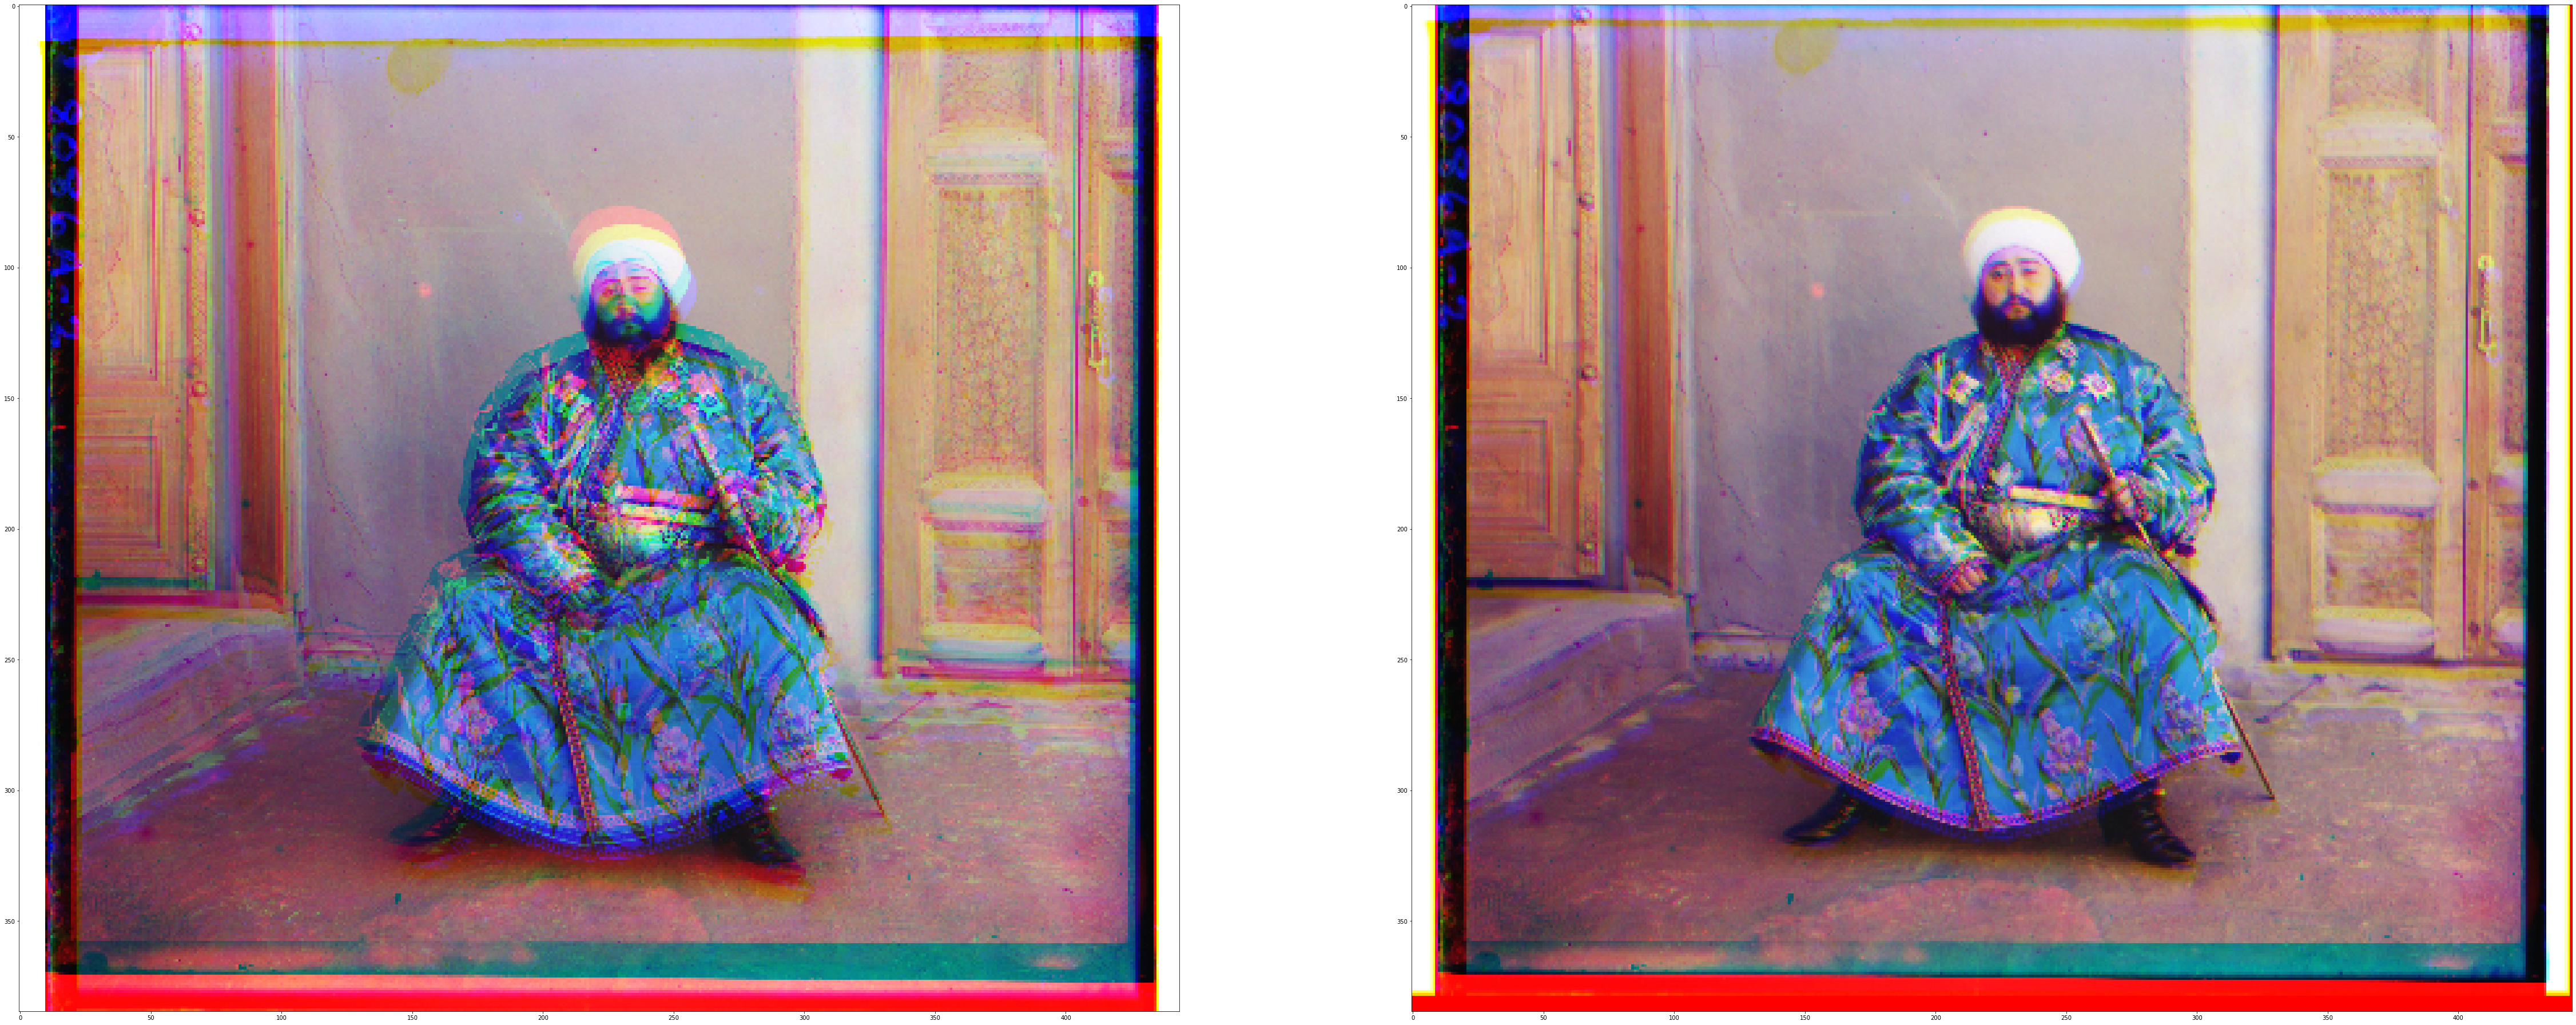

In [102]:
x = align_pg(pics[9])
display(pics[9],x)

### Scikit-image implementation

In [109]:
def align_pg2(pics):
    height = pics.T[0].shape[0]
    width = pics.T[0].shape[1]
    image1 = pics.T[2][int(height/20):height - int(height/20),int(width/20):width - int(width/20)]/255
    image2 = pics.T[1][int(height/20):height - int(height/20),int(width/20):width - int(width/20)]/255
    image3 = pics.T[0][int(height/20):height - int(height/20),int(width/20):width - int(width/20)]/255
    correction = [image2,image3]
    out = [(image1*255).astype('uint8')]
    
    for x in correction:
        # pixel precision first
        shift, error, diffphase = register_translation(image1, x)
        shifted = scipy.ndimage.shift(x,shift)
        out.append((shifted*255).astype('uint8'))
        print(f"Detected pixel offset (y, x): {shift}")
    return out


Detected pixel offset (y, x): [-3. -1.]
Detected pixel offset (y, x): [-1. -2.]


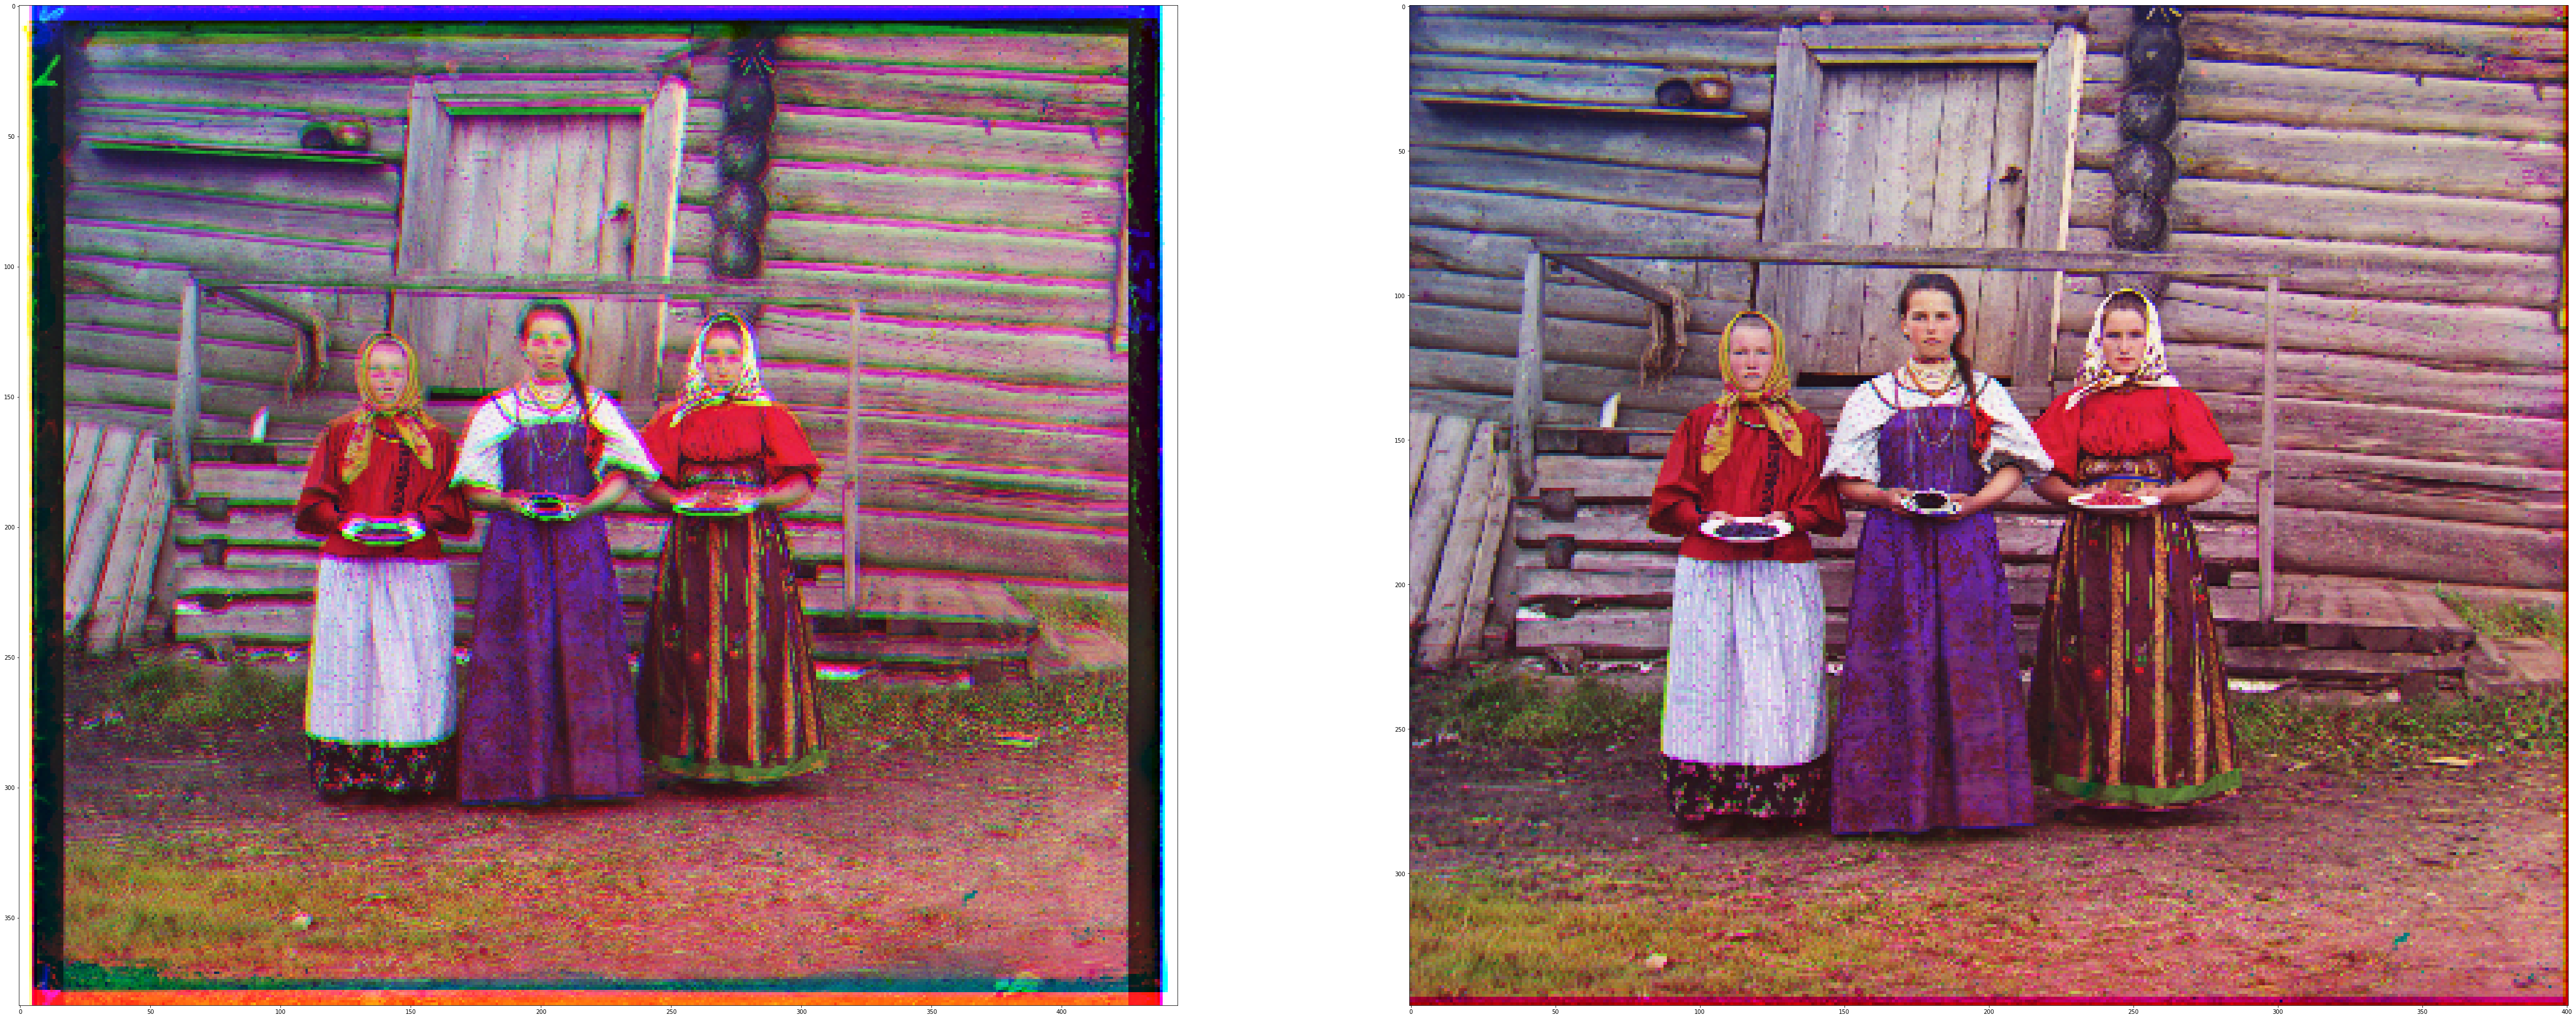

In [111]:
x = align_pg2(pics[4])
display(pics[4],x)

### Numpy implementation

In [69]:
def align_gp3(pics,maxR):
    height = pics.T[0].shape[0]
    width = pics.T[0].shape[1]
    image1 = pics.T[2][int(height/20):height - int(height/20),int(width/20):width - int(width/20)]/255
    image2 = pics.T[1][int(height/20):height - int(height/20),int(width/20):width - int(width/20)]/255
    image3 = pics.T[0][int(height/20):height - int(height/20),int(width/20):width - int(width/20)]/255
    correction = [image2,image3]
    out = [(image1*255).astype('uint8')]
    for x in correction: 
        bestC = 0
        bestP = image2
        offset = []
        for y in range(-maxR,maxR):
            for z in range(-maxR, maxR):
                new = numpy.roll(x,(y,z),(0,1))
                cor = np.correlate(image1.flatten(),new.flatten())
                if cor > bestC:
                    offset = (y,z)
                    bestP = new
                    bestC = cor
        out.append((bestP*255).astype('uint8'))
        print("Optimal alignment: " + str(offset))
    return out
    

Optimal alignment: (-9, -3)
Optimal alignment: (-17, -7)


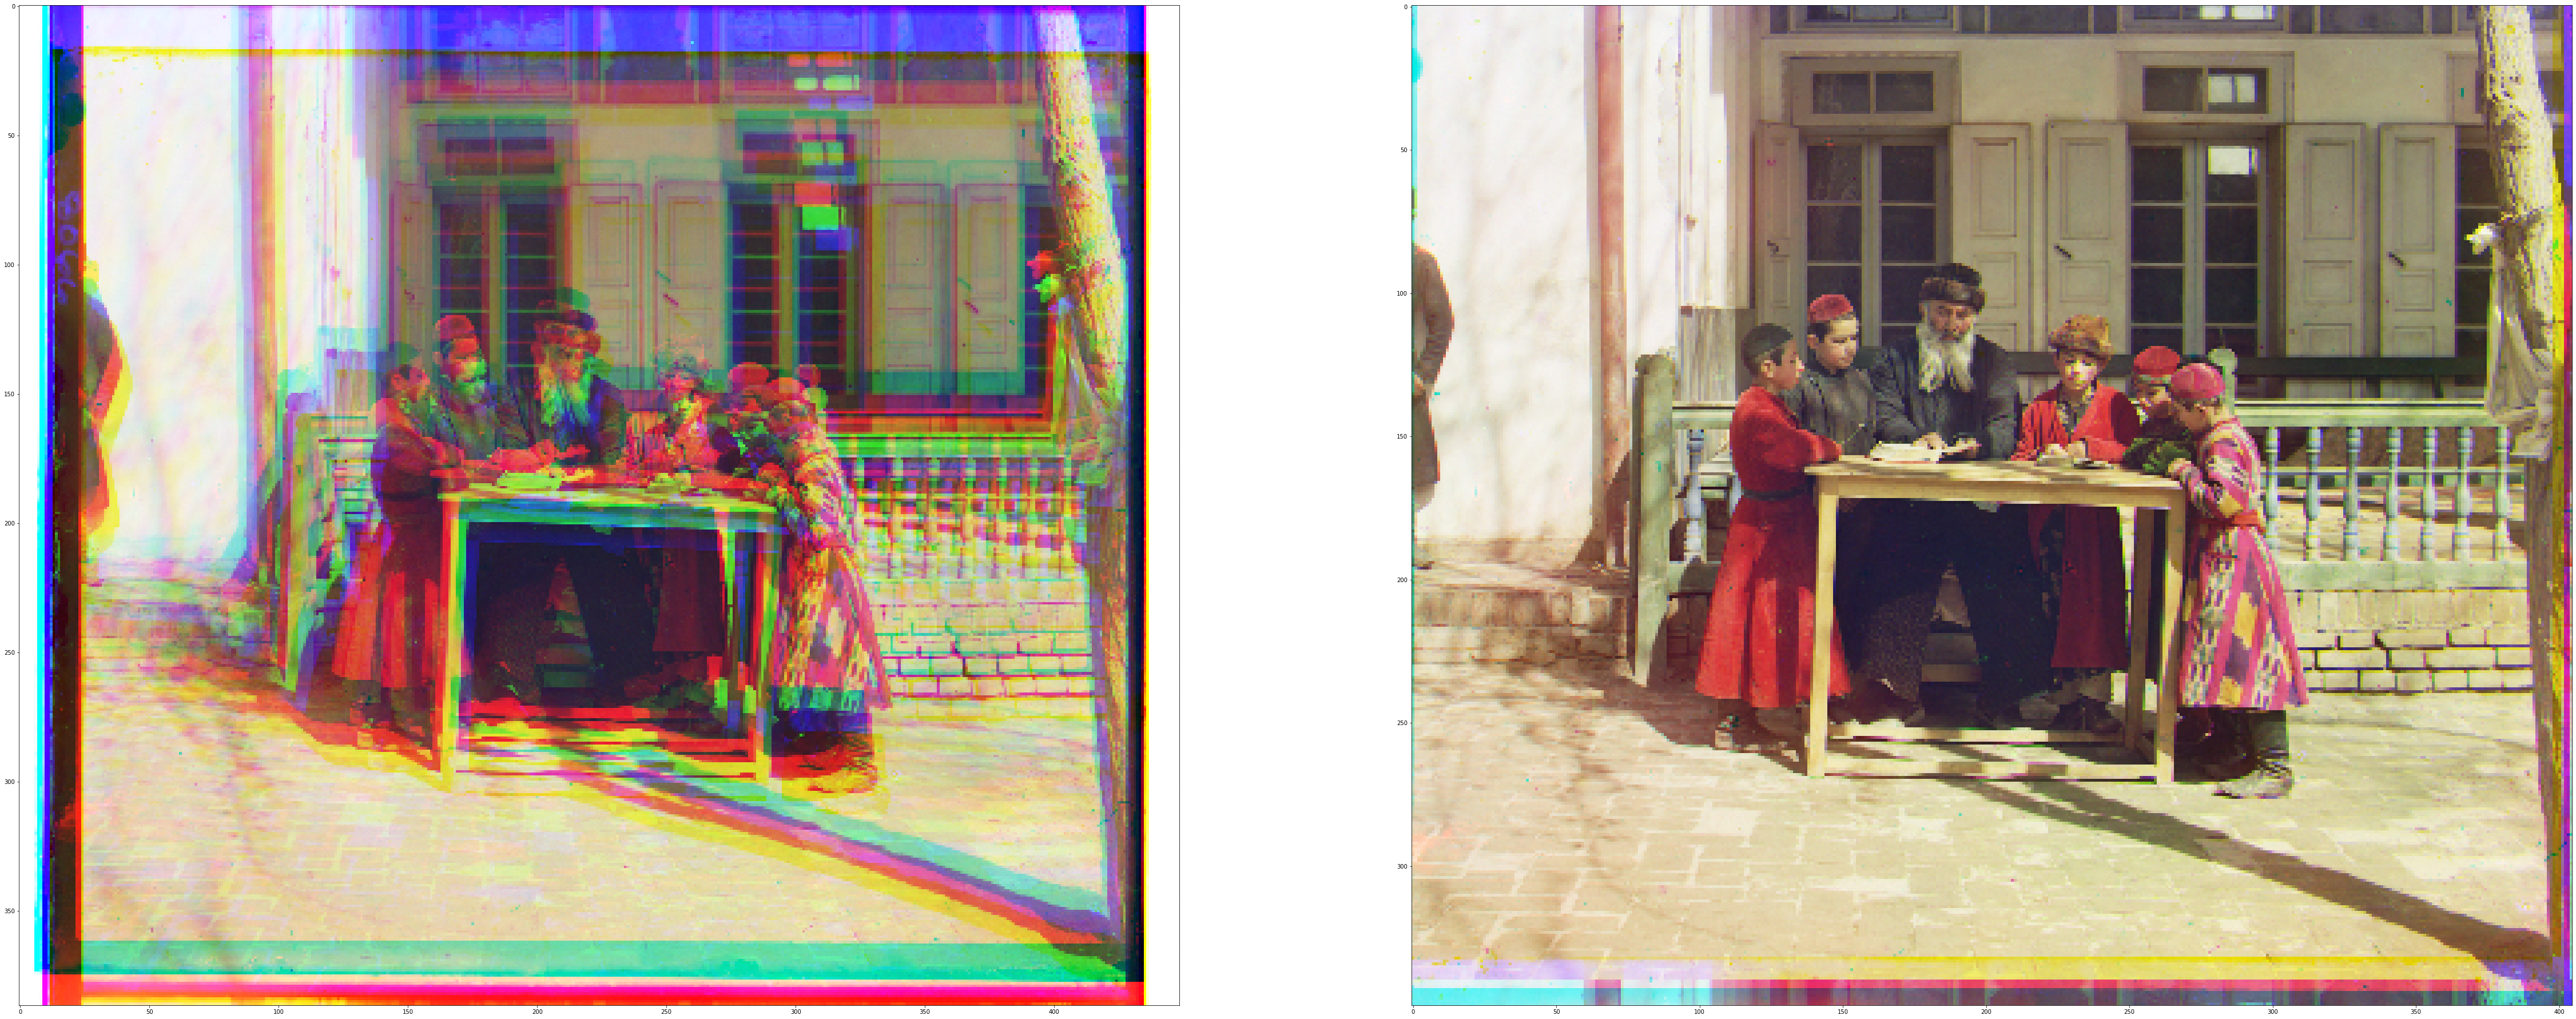

In [80]:
x = align_gp3(pics[8],20)
display(pics[8],x)